In [44]:
import concurrent.futures # for asynchronous execution of callables
import collections  # library for ADTs
import dataclasses  # classes for only storing data
import hashlib  # for efficient hashing of files
import itertools  # custom iterators
import json # data presentation tool
import math
import os
import pathlib
import random
import re # regular expression matching operations; e.g. for encoding "\n" as it is rather than as newline
import string # common string ops
import time
import urllib.request

import einops # for tensor manipulations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests # make request to http page
import tqdm

import tensorflow as tf
import tensorflow_hub as hub  # repo of pretrained models
import tensorflow_text as text  # text processing
import tensorflow_datasets as tfds

In [45]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [46]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:  # total data, if less, download again
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines() # split into strings (each string = one image name and its caption) and store it in a list
  captions = (line.split('\t') for line in captions)  # split each element of above list as list of [image name, caption]
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)  # splits image name at # char (this was to give indexing to different captions of the same image) and stores it with corres caption

  cap_dict = collections.defaultdict(list)  # store pairs as dict
  for fname, cap in captions:
    cap_dict[fname].append(cap) # for a key in the dict, we have list of strings as value

  # following two store tuples of [image_path, caption] in corresponding list
  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  # Creates a Dataset comprising the given list of elements
  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

Calling the above defined functions to download the dataset:

In [47]:
train_raw, test_raw = flickr8k()

In [48]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [49]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  # im = Image.open(tf.strings.as_string(ex_path))
  # im.show()
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


Image feature extractor
Add notes later

In [50]:
IMAGE_SHAPE=(224, 224, 3)
resnet50 = tf.keras.applications.resnet50.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights = 'imagenet')
resnet50.trainable=False

In [51]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [52]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [53]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]
# print(type(test_img_batch))
# test_img_batch_1 = tf.reshape(test_img_batch, (224,224,3))
# print(test_img_batch.type)
# plt.imshow(test_img_batch_1)
im = tensor_to_image(test_img_batch)
im.show()
print(test_img_batch.shape)
# print(resnet50(test_img_batch).shape)

(1, 224, 224, 3)


In [54]:
def standardize(s):
  s = tf.strings.lower(s) # converts into lowercase
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '') # retains punctuations as it is
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [55]:
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True # allows elements with different
    )

In [56]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))  # map applies transformation i.e. the lambda func on train_raw, which extracts only caption data and feeds to the tokeniser

In [57]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [58]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [59]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [60]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [61]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy() # why?

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

In [62]:
def match_shapes(images, captions): # replicate the image so there are 1:1 images to captions
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [63]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [64]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1] # slicing operator
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [65]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)  # AUTOTUNE optimizes data pipeline by tuning params while running
          .unbatch()                # because each batch now had 160 (img, caption) pairs
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [66]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [67]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [68]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq) ~eqt to [[seq]]
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [69]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [70]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [71]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [72]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [73]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):  # for initializing weights of feed forward layer
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [74]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

0it [00:00, ?it/s]

938it [00:08, 112.96it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


In [75]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,  # can tweak
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [76]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [77]:
model = Captioner(tokenizer, feature_extractor=resnet50, output_layer=output_layer,
                  units=192, dropout_rate=0.4, num_layers=3, num_heads=3)

In [78]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

In [79]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)  # calls 'call()' method of Captioner
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [80]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a

a man yellow the down


In [81]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)  # sparse bcz labels belong to a limited fixed dict only

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)  # to prevent blowing up of values
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask) # correct preds / total nonzero labels
  return acc

Can use a new image while training again

In [82]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [83]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a
a a on a a a a
staring sequined a umbrella young to railing snow a of



In [84]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)]

In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [86]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=50,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=1000,
    callbacks=callbacks)

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 5.0897 - masked_acc: 0.1727

a man in a in a in a in a in a in a in a in a in a in a in a in a in a man
a in in a on a of a in a water
people in by boys appear sledding woods water

50/50 [==============================] - 90s 2s/step - loss: 5.0897 - masked_acc: 0.1727 - val_loss: 4.8981 - val_masked_acc: 0.2134
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 4.8472 - masked_acc: 0.2304

a man in a man in a man in a man
a man in a man in a man in a up
two after across dog surfboard small her down a crocks

50/50 [==============================] - 79s 2s/step - loss: 4.8472 - masked_acc: 0.2304 - val_loss: 4.6738 - val_masked_acc: 0.2459
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 4.7043 - masked_acc: 0.2444

a man in a man in a man in a man in a man
a man in a a man in the grass
a dog in a little grassy a group

50/50 [==============================] - 78s 2s/step - lo

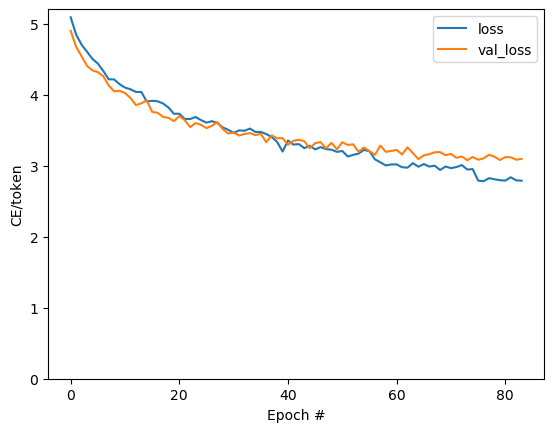

In [87]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

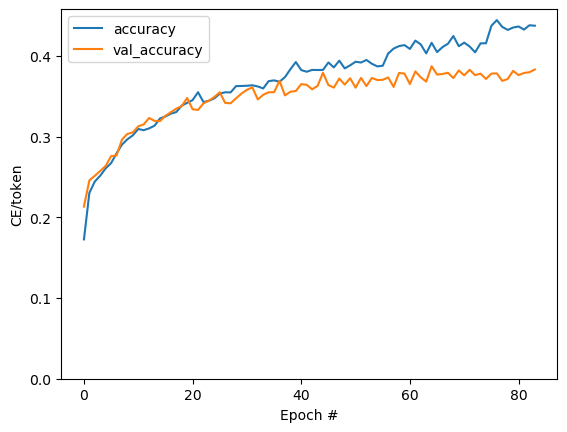

In [88]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [89]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red shirt is riding a wave'

In [94]:
str_tokens = result.split()
str_tokens.append('[END]')

In [90]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 3, 11, 49]),
 TensorShape([1, 3, 11, 49]),
 TensorShape([1, 3, 11, 49])]

In [95]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')


In [97]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 0.99999994, 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        ], dtype=float32)>

In [102]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()


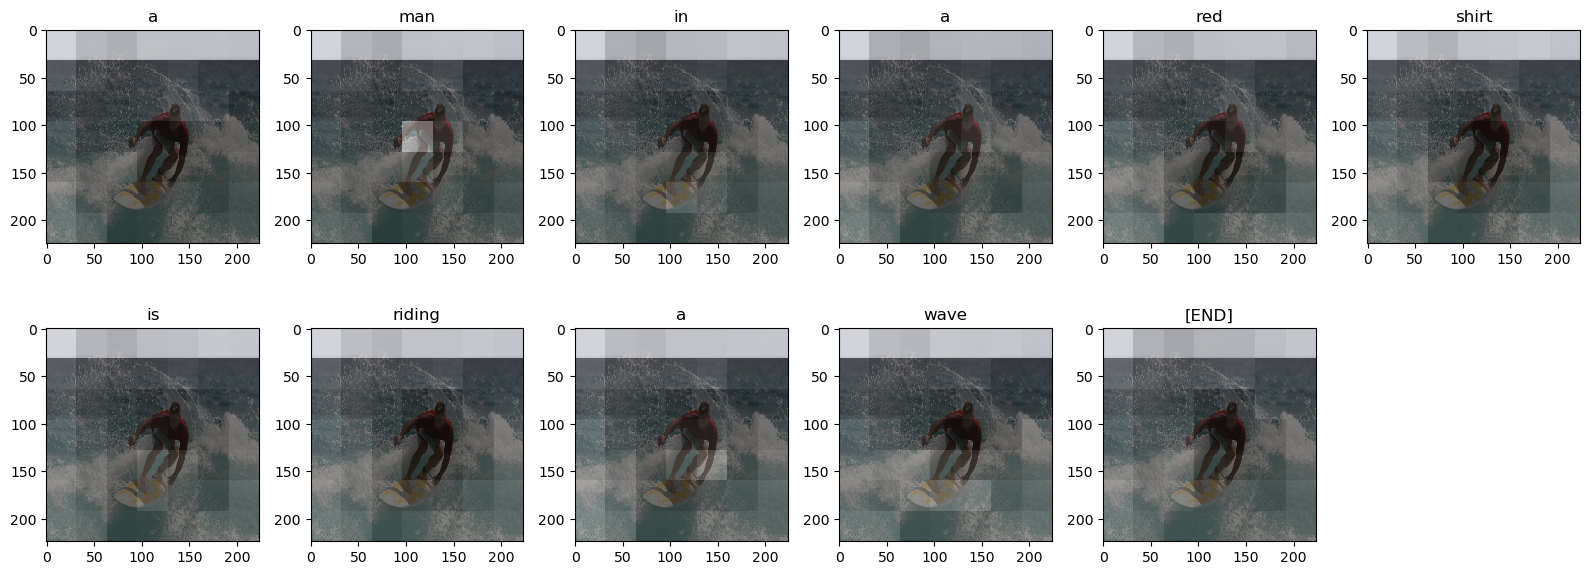

In [103]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [108]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


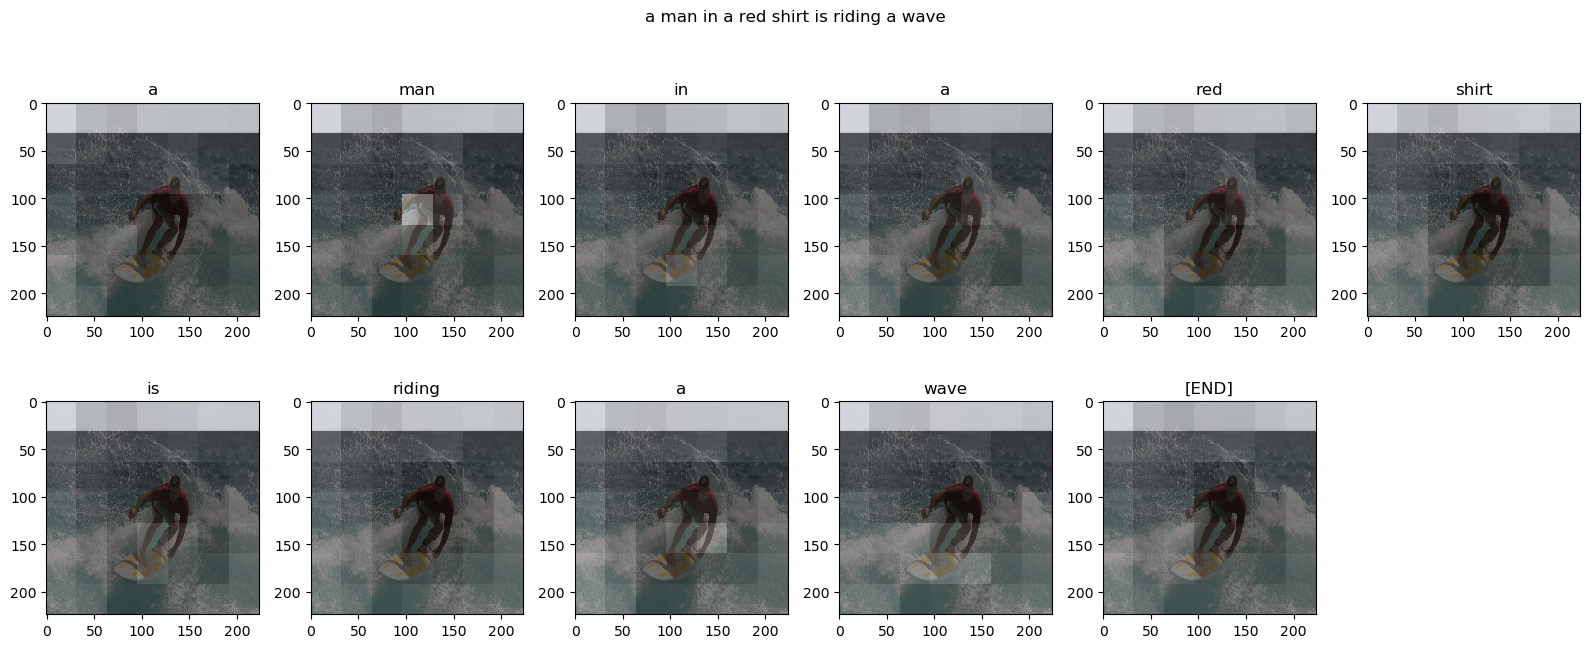

In [109]:
run_and_show_attention(model, image)

63954/63954 [==============================] - 0s 6us/step


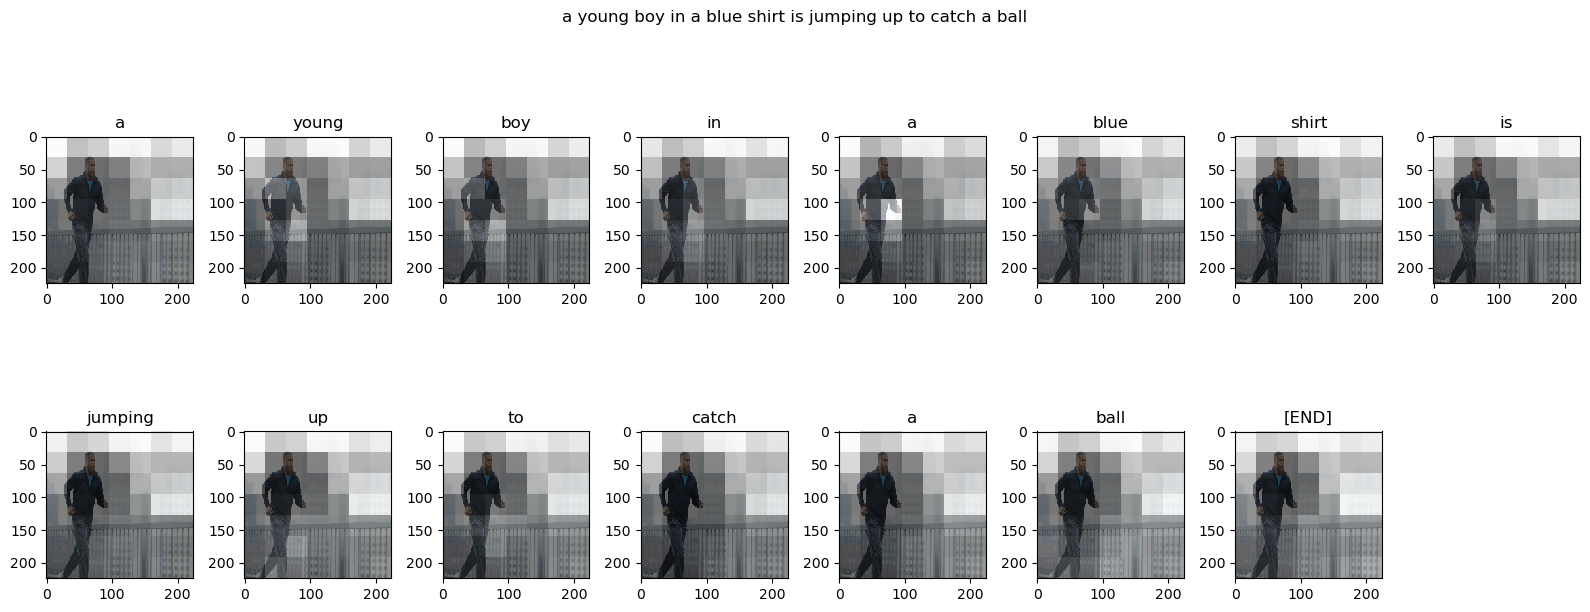

In [115]:
image_url = 'http://content.health.harvard.edu/wp-content/uploads/2023/05/2434e7c0-3082-4e6a-9556-3e36e6f38b4c.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)